### **INFO**
this notebook is written by Japanese.

# 要約
このNotebookではA/Btestを行ったデータを基に、それぞれのデータの分散や効果の比較を行った。
いくつかデータに変更を加え、それによって得られたデータから結論を行い、最終的にA/Bテストの結果を示す。

# データの概要

> このサイトは収入を増やすために A/B テストを開始しました。 Excel ファイルには、実験結果 (user_id)、サンプル タイプ (variant_name)、およびユーザーによってもたらされた収入 (収益) に関する生データが含まれています。

https://www.kaggle.com/datasets/sergylog/ab-test-data/data

このデータセットは10000行3列です。

|Feature|Example|D-type|Null-Count|
|----|----|----|----|
|USER_ID|737|int64|0|
|VARIANT_NAME|variant|object|0|
|REVENUE|0.0|float64|0|

# 分析

## ライブラリ

In [34]:
%matplotlib inline

# データ処理のためのライブラリ
import numpy as np
import pandas as pd

# データ可視化のためのライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# 検定用のライブラリ
import scipy

# warningの無視
import warnings
warnings.simplefilter("ignore")

# すべての列の表示
pd.set_option("display.max_columns",None)

## データの取得と概要

In [35]:
# データの取得と表示
df = pd.read_csv("/kaggle/input/ab-test-data/AB_Test_Results.csv")
df.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [36]:
# 記述統計量を表示
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [37]:
# データの情報を表示
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [38]:
# ユニークなデータ数を表示
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [39]:
# 重複した行の表示
df.duplicated().sum()

2067

重複した行が非常多いので、重複した行を除外して考える。

In [40]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## データの可視化と除外値の選定

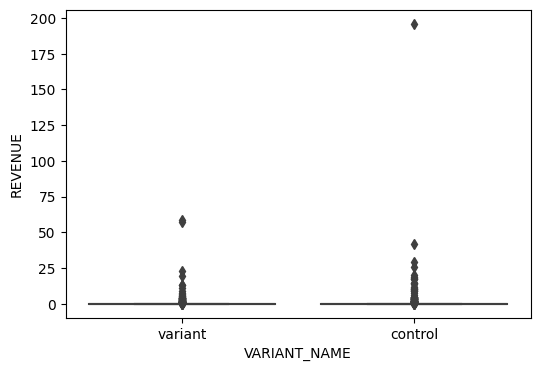

In [41]:
# 介入の有無別の分布
plt.figure(figsize=(6,4))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()

In [42]:
# 外れ値の確認
df.sort_values(by="REVENUE",ascending=False).head(5)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32


USER_ID 3342は他と比べて大きく外れているので今回は除外して考える。

In [43]:
df = df[df["USER_ID"] != 3342]

除外したのちにもう一度描画

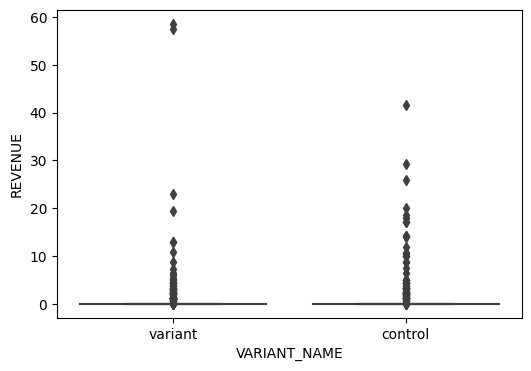

In [44]:
# 介入の有無別分布
plt.figure(figsize=(6,4))
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)
plt.show()

目的関数(REVENUE)が0のものが多いので、割合を調査する。

In [45]:
# 目的関数の0の割合

print("全データ：",len(df[df["REVENUE"]==0])/len(df))

df_0 = df[df['VARIANT_NAME']=="variant"]
df_1 = df[df['VARIANT_NAME']=="control"]

print("対照群：",len(df_0[df_0["REVENUE"]==0])/len(df_0))
print("介入群：",len(df_1[df_1["REVENUE"]==0])/len(df_1))

全データ： 0.9809631870902673
対照群： 0.9818181818181818
介入群： 0.980110775427996


# 効果検証

In [46]:
df_0 = df[df['VARIANT_NAME']=="variant"]
df_1 = df[df['VARIANT_NAME']=="control"]

介入を行った群のことを**介入群**、介入を行わなかった群のことを**対照群**と呼ぶ。

まずはそれぞれの群の平均と分散を確認する

In [47]:
print("対照群")
print("平均：",df_0["REVENUE"].mean(),"分散：",df_0["REVENUE"].var())

print("介入群")
print("平均：",df_1["REVENUE"].mean(),"分散：",df_1["REVENUE"].var())

対照群
平均： 0.08875505050505052 分散： 2.1881493211414473
介入群
平均： 0.11253524672708963 分散： 1.6834481415425482


次に介入によって収入が増加したかどうかを検証する。これらの検証のためにまずは等分散性を満たすかどうかを検定する。帰無仮説と対立仮説は以下のように設定する。
### H<sub>0</sub>：2群間のデータの分散は等しい
### H<sub>1</sub>：2群間のデータの分散は等しくない
これらの仮説を検証するためにF検定を行う。

In [48]:
scipy.stats.bartlett(df_0["REVENUE"],df_1["REVENUE"])

BartlettResult(statistic=67.95938401476576, pvalue=1.6689822377382765e-16)

p値が1.6689822377382765e-16であることからH<sub>0</sub>は棄却され、2つの群の分散が等しいとは言えない。
次に正規分布に従っているか判定するためにシャピロ―の検定を行う。帰無仮説と対立仮説は以下のように設定する。

### H<sub>0</sub>：データは正規分布に従っている
### H<sub>1</sub>：データは正規分布に従っていない

In [49]:
print("対照群：",scipy.stats.shapiro(df_0["REVENUE"]))

print("介入群：",scipy.stats.shapiro(df_1["REVENUE"]))

対照群： ShapiroResult(statistic=0.032665252685546875, pvalue=0.0)
介入群： ShapiroResult(statistic=0.06078881025314331, pvalue=0.0)


いずれの群もp値が0.0であることからH<sub>0</sub>は棄却され、それぞれの群は正規分布に従っているとは言えない。
最後に介入の効果があったかどうか判定するためにMann-Whitney(マンホイットニー)の片側U検定を行う。帰無仮説と対立仮説は以下のように設定する。

### H<sub>0</sub>：2群間のデータに差がない
### H<sub>1</sub>：2群間のデータに差がある（介入群のデータの方が収入が大きい）

In [50]:
scipy.stats.mannwhitneyu(df_0["REVENUE"], df_1["REVENUE"], alternative='greater')

MannwhitneyuResult(statistic=7850692.0, pvalue=0.7172068674841511)

p値が0.7172068674841511であることからH<sub>0</sub>は棄却されず、2つの群のデータに有意差はないことが分かった。

## 別の視点で考えてみる
対象群と介入群で同じUSER_IDを持つデータに対して、介入効果があるかどうか検証する。
目的関数が0のデータが多く、非0であるものが少ない。USER_IDが複数ある場合、集計として今回は外れ値に強い「中央値」を用いる。

In [51]:
# USER_IDごとに集計
df_0_ID = df_0.groupby("USER_ID").agg({"REVENUE":"median"}).reset_index().rename({'REVENUE': 'REVENUE_0'}, axis='columns')
df_1_ID = df_1.groupby("USER_ID").agg({"REVENUE":"median"}).reset_index().rename({'REVENUE': 'REVENUE_1'}, axis='columns')

df_0_ID

,USER_ID,REVENUE_0
0,3,0.00
1,4,0.00
2,5,0.00
3,6,0.00
4,9,0.00
...,...,...
3929,9986,0.00
3930,9990,0.00
3931,9995,0.00
3932,9996,6.46


In [52]:
# USER_IDをkeyとして内部結合し、差を計算
df_ID = pd.merge(df_0_ID, df_1_ID, on='USER_ID', how="inner")
df_ID["diff"] = df_ID["REVENUE_1"] - df_ID["REVENUE_0"]
df_ID

,USER_ID,REVENUE_0,REVENUE_1,diff
0,3,0.00,0.0,0.00
1,10,0.00,0.0,0.00
2,18,0.00,0.0,0.00
3,25,0.00,0.0,0.00
4,40,0.00,0.0,0.00
...,...,...,...,...
1536,9978,0.00,0.0,0.00
1537,9979,0.00,0.0,0.00
1538,9982,0.00,0.0,0.00
1539,9996,6.46,0.0,-6.46


In [53]:
# 統計量を表示
df_ID.describe()

,USER_ID,REVENUE_0,REVENUE_1,diff
count,1541.000000,1541.000000,1541.000000,1541.000000
mean,4952.189487,0.085428,0.073764,-0.011665
std,2879.108660,1.668343,1.188610,2.051280
min,3.000000,0.000000,0.000000,-57.460000
25%,2444.000000,0.000000,0.000000,0.000000
50%,4962.000000,0.000000,0.000000,0.000000
75%,7476.000000,0.000000,0.000000,0.000000
max,10000.000000,57.460000,41.530000,41.530000


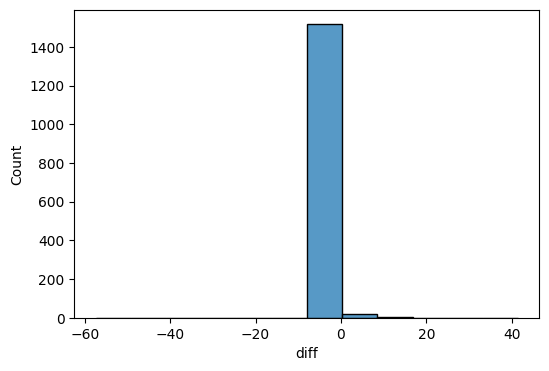

In [54]:
# diffをヒストグラムで出力
plt.figure(figsize=(6,4))
sns.histplot(x='diff', data=df_ID)
plt.show()

この差が正規分布と仮定できるかどうかを検定する。
### H<sub>0</sub>：データは正規分布に従っている
### H<sub>1</sub>：データは正規分布に従っていない

In [55]:
print(scipy.stats.shapiro(df_ID["diff"]))

ShapiroResult(statistic=0.05677109956741333, pvalue=0.0)


p値が0.0であることからH<sub>0</sub>は棄却され、差は正規分布に従っているとは言えない。
介入の効果があったかどうか判定するためにWilcoxon(ウィルコクソン)の符号付順位和検定を行う。帰無仮説と対立仮説は以下のように設定する。

### H<sub>0</sub>：2群間のデータに差がない
### H<sub>1</sub>：2群間のデータに差がある

In [56]:
# Wilcoxon(ウィルコクソン)の符号付順位和検定
scipy.stats.wilcoxon(df_ID["REVENUE_0"], df_ID["REVENUE_1"])

WilcoxonResult(statistic=716.0, pvalue=0.8195069035669128)

p値が0.8195069035669128であることからH<sub>0</sub>は棄却されず、2つの群のデータに有意差はないことが分かった。

# 結論

A/Bテストの結果を用いて、2通りの方法で介入効果の検証を行った。
まずデータの前処理として、USER_IDが3342のデータは外れ値であると判断したため削除を行い、重複データが多く存在したためそれらも削除した。
全体のデータを対象とした検証方法と、同一のUSER_IDを持つデータでの介入の効果検証方法を行ったが、いずれの方法でも介入効果が有意であると判断することはできない。
ネクストアクションとして、以下のことが挙げられる。

1. 「難しい特徴量を用いた」と記載されているので、簡単な特徴量を用いたA/Bテストを行う
2. A/Aテストを実施してみる
3. 重複したデータが多かったので、データの取得方法を変更してみる（同一ユーザの観測回数を限定するなど）
4. 別の施策でA/Bテストを実行する